In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 200)
plt.style.use('ggplot')

# Import KNeighborsClassifier from sklearn.neighbors
from sklearn.neighbors import KNeighborsClassifier

# Import DecisionTreeClassifier from sklearn.tree
from sklearn.tree import DecisionTreeClassifier

# Import RandomForestClassifier
from sklearn.ensemble import RandomForestClassifier

# Import LogisticRegression
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, auc

In [6]:
df = pd.read_csv('data/US_Accidents_June20.csv', keep_default_na=False)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16517 entries, 0 to 16516
Data columns (total 49 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   ID                     16517 non-null  object 
 1   Source                 16517 non-null  object 
 2   TMC                    16517 non-null  float64
 3   Severity               16517 non-null  int64  
 4   Start_Time             16517 non-null  object 
 5   End_Time               16517 non-null  object 
 6   Start_Lat              16517 non-null  float64
 7   Start_Lng              16517 non-null  float64
 8   End_Lat                16517 non-null  object 
 9   End_Lng                16517 non-null  object 
 10  Distance(mi)           16517 non-null  float64
 11  Description            16517 non-null  object 
 12  Number                 16517 non-null  object 
 13  Street                 16517 non-null  object 
 14  Side                   16517 non-null  object 
 15  Ci

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3072: DtypeWarning: Columns (23,25,26,27,38,39,40,41,42,43,44) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [7]:
# Convert Start_Time and End_Time to datetypes
df['Start_Time'] = pd.to_datetime(df['Start_Time'], errors='coerce')
df['End_Time'] = pd.to_datetime(df['End_Time'], errors='coerce')

# Extract year, month, day, hour and weekday
df['Year']=df['Start_Time'].dt.year
df['Month']=df['Start_Time'].dt.strftime('%b')
df['Day']=df['Start_Time'].dt.day
df['Hour']=df['Start_Time'].dt.hour
df['Weekday']=df['Start_Time'].dt.strftime('%a')

# Extract the amount of time in the unit of minutes for each accident, round to the nearest integer
td='Time_Duration(min)'
df[td]=round((df['End_Time']-df['Start_Time'])/np.timedelta64(1,'m'))
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16517 entries, 0 to 16516
Data columns (total 55 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   ID                     16517 non-null  object        
 1   Source                 16517 non-null  object        
 2   TMC                    16517 non-null  float64       
 3   Severity               16517 non-null  int64         
 4   Start_Time             16517 non-null  datetime64[ns]
 5   End_Time               16517 non-null  datetime64[ns]
 6   Start_Lat              16517 non-null  float64       
 7   Start_Lng              16517 non-null  float64       
 8   End_Lat                16517 non-null  object        
 9   End_Lng                16517 non-null  object        
 10  Distance(mi)           16517 non-null  float64       
 11  Description            16517 non-null  object        
 12  Number                 16517 non-null  object        
 13  S

In [8]:
df[td][df[td]<=0]

Series([], Name: Time_Duration(min), dtype: float64)

In [9]:
neg_outliers=df[td]<=0

# Set outliers to NAN
df[neg_outliers] = np.nan

# Drop rows with negative td
df.dropna(subset=[td],axis=0,inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16517 entries, 0 to 16516
Data columns (total 55 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   ID                     16517 non-null  object        
 1   Source                 16517 non-null  object        
 2   TMC                    16517 non-null  float64       
 3   Severity               16517 non-null  float64       
 4   Start_Time             16517 non-null  datetime64[ns]
 5   End_Time               16517 non-null  datetime64[ns]
 6   Start_Lat              16517 non-null  float64       
 7   Start_Lng              16517 non-null  float64       
 8   End_Lat                16517 non-null  object        
 9   End_Lng                16517 non-null  object        
 10  Distance(mi)           16517 non-null  float64       
 11  Description            16517 non-null  object        
 12  Number                 16517 non-null  object        
 13  S

In [10]:
# Double check to make sure no more negative td
df[td][df[td]<=0]


Series([], Name: Time_Duration(min), dtype: float64)

In [11]:
# Remove outliers for Time_Duration(min): n * standard_deviation (n=3), backfill with median

n=3

median = df[td].median()
std = df[td].std()
outliers = (df[td] - median).abs() > std*n

# Set outliers to NAN
df[outliers] = np.nan

# Fill NAN with median
df[td].fillna(median, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16517 entries, 0 to 16516
Data columns (total 55 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   ID                     16334 non-null  object        
 1   Source                 16334 non-null  object        
 2   TMC                    16334 non-null  float64       
 3   Severity               16334 non-null  float64       
 4   Start_Time             16334 non-null  datetime64[ns]
 5   End_Time               16334 non-null  datetime64[ns]
 6   Start_Lat              16334 non-null  float64       
 7   Start_Lng              16334 non-null  float64       
 8   End_Lat                16334 non-null  object        
 9   End_Lng                16334 non-null  object        
 10  Distance(mi)           16334 non-null  float64       
 11  Description            16334 non-null  object        
 12  Number                 16334 non-null  object        
 13  S

In [12]:
# Print time_duration information
print('Max time to clear an accident: {} minutes or {} hours or {} days; Min to clear an accident td: {} minutes.'.format(df[td].max(),round(df[td].max()/60), round(df[td].max()/60/24), df[td].min()))

Max time to clear an accident: 112.0 minutes or 2 hours or 0 days; Min to clear an accident td: 10.0 minutes.


In [13]:
feature_lst=['Source','TMC','Severity','Start_Lng','Start_Lat','Distance(mi)','Side','City','County','State','Timezone','Temperature(F)','Humidity(%)','Pressure(in)', 'Visibility(mi)', 'Wind_Direction','Weather_Condition','Amenity','Bump','Crossing','Give_Way','Junction','No_Exit','Railway','Roundabout','Station','Stop','Traffic_Calming','Traffic_Signal','Turning_Loop','Sunrise_Sunset','Hour','Weekday', 'Time_Duration(min)']

In [14]:
df_sel=df[feature_lst].copy()
df_sel.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16517 entries, 0 to 16516
Data columns (total 34 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Source              16334 non-null  object 
 1   TMC                 16334 non-null  float64
 2   Severity            16334 non-null  float64
 3   Start_Lng           16334 non-null  float64
 4   Start_Lat           16334 non-null  float64
 5   Distance(mi)        16334 non-null  float64
 6   Side                16334 non-null  object 
 7   City                16334 non-null  object 
 8   County              16334 non-null  object 
 9   State               16334 non-null  object 
 10  Timezone            16334 non-null  object 
 11  Temperature(F)      16334 non-null  object 
 12  Humidity(%)         16334 non-null  object 
 13  Pressure(in)        16334 non-null  object 
 14  Visibility(mi)      16334 non-null  object 
 15  Wind_Direction      16334 non-null  object 
 16  Weat

In [15]:
df_sel.isnull().mean()

Source                0.011079
TMC                   0.011079
Severity              0.011079
Start_Lng             0.011079
Start_Lat             0.011079
Distance(mi)          0.011079
Side                  0.011079
City                  0.011079
County                0.011079
State                 0.011079
Timezone              0.011079
Temperature(F)        0.011079
Humidity(%)           0.011079
Pressure(in)          0.011079
Visibility(mi)        0.011079
Wind_Direction        0.011079
Weather_Condition     0.011079
Amenity               0.011079
Bump                  0.011079
Crossing              0.011079
Give_Way              0.011079
Junction              0.011079
No_Exit               0.011079
Railway               0.011079
Roundabout            0.011079
Station               0.011079
Stop                  0.011079
Traffic_Calming       0.011079
Traffic_Signal        0.011079
Turning_Loop          0.011079
Sunrise_Sunset        0.011079
Hour                  0.011079
Weekday 

In [16]:
df_sel.dropna(subset=df_sel.columns[df_sel.isnull().mean()!=0], how='any', axis=0, inplace=True)
df_sel.shape

(16334, 34)

In [17]:
# Set state
state='CA'

# Select the state of Pennsylvania
df_state=df_sel.loc[df_sel.State==state]
df_state.drop('State',axis=1, inplace=True)
df_state.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15667 entries, 728 to 16516
Data columns (total 33 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Source              15667 non-null  object 
 1   TMC                 15667 non-null  float64
 2   Severity            15667 non-null  float64
 3   Start_Lng           15667 non-null  float64
 4   Start_Lat           15667 non-null  float64
 5   Distance(mi)        15667 non-null  float64
 6   Side                15667 non-null  object 
 7   City                15667 non-null  object 
 8   County              15667 non-null  object 
 9   Timezone            15667 non-null  object 
 10  Temperature(F)      15667 non-null  object 
 11  Humidity(%)         15667 non-null  object 
 12  Pressure(in)        15667 non-null  object 
 13  Visibility(mi)      15667 non-null  object 
 14  Wind_Direction      15667 non-null  object 
 15  Weather_Condition   15667 non-null  object 
 16  Am

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


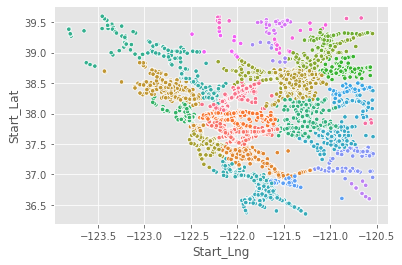

In [18]:
sns.scatterplot(x='Start_Lng', y='Start_Lat', data=df_state, hue='County', legend=False, s=20)
plt.show()


In [19]:
df_state_dummy = pd.get_dummies(df_state,drop_first=True)

In [20]:
df=df_state_dummy


# Set the target for the prediction
target='Severity'



# Create arrays for the features and the response variable

# set X and y
y = df[target]
X = df.drop(target, axis=1)

# Split the data set into training and testing data sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=21, stratify=y)

In [21]:
# List of classification algorithms
algo_lst=['Logistic Regression',' K-Nearest Neighbors','Decision Trees','Random Forest']

# Initialize an empty list for the accuracy for each algorithm
accuracy_lst=[]

In [22]:
lr = LogisticRegression(random_state=0)
lr.fit(X_train,y_train)
y_pred=lr.predict(X_test)

# Get the accuracy score
acc=accuracy_score(y_test, y_pred)

# Append to the accuracy list
accuracy_lst.append(acc)

print("[Logistic regression algorithm] accuracy_score: {:.3f}.".format(acc))

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


[Logistic regression algorithm] accuracy_score: 0.831.


In [25]:
# Create a k-NN classifier with 6 neighbors
knn = KNeighborsClassifier(n_neighbors=6)

# Fit the classifier to the data
knn.fit(X_train,y_train)

# Predict the labels for the training data X
y_pred = knn.predict(X_test)

# Get the accuracy score
acc=accuracy_score(y_test, y_pred)

# Append to the accuracy list
accuracy_lst.append(acc)

print('[K-Nearest Neighbors (KNN)] knn.score: {:.3f}.'.format(knn.score(X_test, y_test)))
print('[K-Nearest Neighbors (KNN)] accuracy_score: {:.3f}.'.format(acc))

[K-Nearest Neighbors (KNN)] knn.score: 0.715.
[K-Nearest Neighbors (KNN)] accuracy_score: 0.715.


In [26]:
# Decision tree algorithm

# Instantiate dt_entropy, set 'entropy' as the information criterion
dt_entropy = DecisionTreeClassifier(max_depth=8, criterion='entropy', random_state=1)


# Fit dt_entropy to the training set
dt_entropy.fit(X_train, y_train)

# Use dt_entropy to predict test set labels
y_pred= dt_entropy.predict(X_test)

# Evaluate accuracy_entropy
accuracy_entropy = accuracy_score(y_test, y_pred)


# Print accuracy_entropy
print('[Decision Tree -- entropy] accuracy_score: {:.3f}.'.format(accuracy_entropy))



# Instantiate dt_gini, set 'gini' as the information criterion
dt_gini = DecisionTreeClassifier(max_depth=8, criterion='gini', random_state=1)


# Fit dt_entropy to the training set
dt_gini.fit(X_train, y_train)

# Use dt_entropy to predict test set labels
y_pred= dt_gini.predict(X_test)

# Evaluate accuracy_entropy
accuracy_gini = accuracy_score(y_test, y_pred)

# Append to the accuracy list
acc=accuracy_gini
accuracy_lst.append(acc)

# Print accuracy_gini
print('[Decision Tree -- gini] accuracy_score: {:.3f}.'.format(accuracy_gini))

[Decision Tree -- entropy] accuracy_score: 0.829.
[Decision Tree -- gini] accuracy_score: 0.847.


In [27]:
# Random Forest algorithm

#Create a Gaussian Classifier
clf=RandomForestClassifier(n_estimators=100)

#Train the model using the training sets y_pred=clf.predict(X_test)
clf.fit(X_train,y_train)

y_pred=clf.predict(X_test)


# Get the accuracy score
acc=accuracy_score(y_test, y_pred)

# Append to the accuracy list
accuracy_lst.append(acc)


# Model Accuracy, how often is the classifier correct?
print("[Randon forest algorithm] accuracy_score: {:.3f}.".format(acc))

[Randon forest algorithm] accuracy_score: 0.883.


No handles with labels found to put in legend.


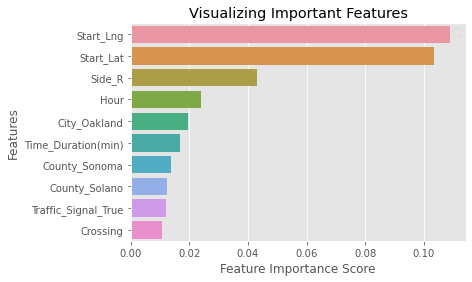

In [29]:
feature_imp = pd.Series(clf.feature_importances_,index=X.columns).sort_values(ascending=False)

# Creating a bar plot, displaying only the top k features
k=10
sns.barplot(x=feature_imp[:10], y=feature_imp.index[:k])
# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.legend()
plt.show()

In [30]:
# List top k important features
k=20
feature_imp.sort_values(ascending=False)[:k]

Start_Lng              0.108754
Start_Lat              0.103368
Side_R                 0.043198
Hour                   0.024061
City_Oakland           0.019580
Time_Duration(min)     0.016758
County_Sonoma          0.013778
County_Solano          0.012250
Traffic_Signal_True    0.011957
Crossing               0.010525
TMC                    0.009308
Junction               0.008732
Stop_True              0.008573
City_Berkeley          0.007749
City_Pleasanton        0.007434
County_San Mateo       0.007152
Distance(mi)           0.007069
City_Fremont           0.006820
County_Santa Clara     0.006543
City_Fairfield         0.006480
dtype: float64

In [31]:
# features that have an importance of more than 0.03
sfm = SelectFromModel(clf, threshold=0.03)

# Train the selector
sfm.fit(X_train, y_train)

feat_labels=X.columns

# Print the names of the most important features
for feature_list_index in sfm.get_support(indices=True):
    print(feat_labels[feature_list_index])

Start_Lng
Start_Lat
Side_R


In [32]:
# Transform the data to create a new dataset containing only the most important features
# Note: We have to apply the transform to both the training X and test X data.
X_important_train = sfm.transform(X_train)
X_important_test = sfm.transform(X_test)

# Create a new random forest classifier for the most important features
clf_important = RandomForestClassifier(n_estimators=100, random_state=0, n_jobs=-1)

# Train the new classifier on the new dataset containing the most important features
clf_important.fit(X_important_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

In [33]:
y_pred = clf.predict(X_test)

# View The Accuracy Of Our Full Feature Model
print('[Randon forest algorithm -- Full feature] accuracy_score: {:.3f}.'.format(accuracy_score(y_test, y_pred)))

# Apply The Full Featured Classifier To The Test Data
y_important_pred = clf_important.predict(X_important_test)

# View The Accuracy Of Our Limited Feature Model
print('[Randon forest algorithm -- Limited feature] accuracy_score: {:.3f}.'.format(accuracy_score(y_test, y_important_pred)))

[Randon forest algorithm -- Full feature] accuracy_score: 0.883.
[Randon forest algorithm -- Limited feature] accuracy_score: 0.924.


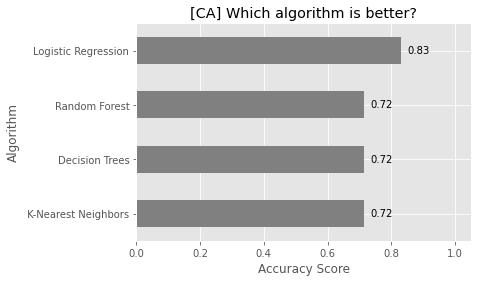

In [34]:

# Generate a list of ticks for y-axis
y_ticks=np.arange(len(algo_lst))

# Combine the list of algorithms and list of accuracy scores into a dataframe, sort the value based on accuracy score
df_acc=pd.DataFrame(list(zip(algo_lst, accuracy_lst)), columns=['Algorithm','Accuracy_Score']).sort_values(by=['Accuracy_Score'],ascending = True)

# Export to a file
df_acc.to_csv('./Accuracy_scores_algorithms_{}.csv'.format(state),index=False)

# Make a plot
ax=df_acc.plot.barh('Algorithm', 'Accuracy_Score', align='center',legend=False,color='0.5')

# Add the data label on to the plot
for i in ax.patches:
    # get_width pulls left or right; get_y pushes up or down
    ax.text(i.get_width()+0.02, i.get_y()+0.2, str(round(i.get_width(),2)), fontsize=10)

# Set the limit, lables, ticks and title
plt.xlim(0,1.05)
plt.xlabel('Accuracy Score')
plt.yticks(y_ticks, df_acc['Algorithm'], rotation=0)
plt.title('[{}] Which algorithm is better?'.format(state))

plt.show()